In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Installs

In [ ]:
!pip install xlsxwriter
!pip install sentencepiece
!pip install transformers
!pip install fairseq fastBPE 
!wget https://public.vinai.io/BERTweet_base_transformers.tar.gz
!tar -xzvf BERTweet_base_transformers.tar.gz

--2021-11-18 16:39:49--  https://public.vinai.io/BERTweet_base_transformers.tar.gz
Resolving public.vinai.io (public.vinai.io)... 99.86.89.70, 99.86.89.64, 99.86.89.124, ...
Connecting to public.vinai.io (public.vinai.io)|99.86.89.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322076118 (307M) [application/x-tar]
Saving to: ‘BERTweet_base_transformers.tar.gz.1’

BERTweet_base_trans 100%[===================>] 307.16M  78.8MB/s    in 4.3s    

2021-11-18 16:39:55 (70.9 MB/s) - ‘BERTweet_base_transformers.tar.gz.1’ saved [322076118/322076118]

BERTweet_base_transformers/
BERTweet_base_transformers/config.json
BERTweet_base_transformers/bpe.codes
BERTweet_base_transformers/model.bin
BERTweet_base_transformers/dict.txt


Imports

In [ ]:
import pandas as pd, numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import StratifiedKFold
import tokenizers
from transformers import RobertaConfig, TFRobertaModel
print('TF version',tf.__version__)

TF version 2.7.0


In [ ]:
from types import SimpleNamespace
from fairseq.data.encoders.fastbpe import fastBPE
from fairseq.data import Dictionary
from sklearn.utils import shuffle

In [ ]:
import json
import tensorflow as tf
import csv
import random
import numpy as np
import sklearn
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

In [ ]:
class BERTweetTokenizer():
    
    def __init__(self,pretrained_path = '/content/BERTweet_base_transformers/'):
        
        self.bpe = fastBPE(SimpleNamespace(bpe_codes= pretrained_path + "bpe.codes"))
        self.vocab = Dictionary()
        self.vocab.add_from_file(pretrained_path + "dict.txt")
        self.cls_token_id = 0
        self.pad_token_id = 1
        self.sep_token_id = 2
        self.pad_token = '<pad>'
        self.cls_token = '<s>'
        self.sep_token = '</s>'
        
    def bpe_encode(self,text):
        return self.bpe.encode(text) # bpe.encode(line)
    
    def encode(self,text,add_special_tokens=False):
        subwords = self.bpe.encode(text)
        input_ids = self.vocab.encode_line(subwords, append_eos=False, add_if_not_exist=False).long().tolist() ## Map subword tokens to corresponding indices in the dictionary
        return input_ids
    
    def tokenize(self,text):
        return self.bpe_encode(text).split()
    
    def convert_tokens_to_ids(self,tokens):
        input_ids = self.vocab.encode_line(' '.join(tokens), append_eos=False, add_if_not_exist=False).long().tolist()
        return input_ids
    
    #from: https://www.kaggle.com/nandhuelan/bertweet-first-look
    def decode_id(self,id):
        return self.vocab.string(id, bpe_symbol = '@@')
    
    def decode_id_nospace(self,id):
        return self.vocab.string(id, bpe_symbol = '@@ ')

    def bert_encode(self, texts, max_len=512):
        all_tokens = []
        all_masks = []
        all_segments = []
        
        for text in texts:
            text = self.bpe.encode(text)
            input_sequence = '<s> ' + text + ' </s>'

            enc = self.vocab.encode_line(input_sequence, append_eos=False, add_if_not_exist=False).long().tolist()   
            enc = enc[:max_len-2]
            
            pad_len = max_len - len(enc)
            
            tokens = enc + [1] * pad_len #input_ids
            pad_masks = [1] * len(enc) + [0] * pad_len #attention_mask
            segment_ids = [0] * max_len #token_type_ids
            
            all_tokens.append(tokens)
            all_masks.append(pad_masks)
            all_segments.append(segment_ids)
        
        return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
def build_model(max_len=512):
    PATH = '/content/BERTweet_base_transformers/'
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    config = RobertaConfig.from_pretrained(PATH+'config.json')
    bert_model = TFRobertaModel.from_pretrained(PATH+'model.bin',config=config,from_pt=True)
    x = bert_model(input_word_ids,attention_mask=input_mask,token_type_ids=segment_ids)

    #pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    #clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(x[0]) 
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Flatten()(net)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

    #print(out.shape)
    
    return model

In [ ]:
hateSpeech_df = pd.read_csv('/content/drive/Shareddrives/Projeto IBRA USP/Coleta de Dados/Datasets - IBRA/E1 - Hate Speech and Offensive Language/labeled_data.csv', dtype={'Class': int, 'Tweet': str})
hateSpeech_df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
general_df = pd.read_csv('/content/drive/Shareddrives/Projeto IBRA USP/Coleta de Dados/Datasets - IBRA/Dataset Geral/training.1600000.processed.noemoticon.csv', encoding = 'latin-1')
general_df.columns = ['class','id','date','query','user','tweet']
general_df.head()

,class,id,date,query,user,tweet
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [ ]:
# Ver se tem valores nulos de tweet
null_tweets = hateSpeech_df[hateSpeech_df['tweet'].isna()]
null_tweets

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet


In [ ]:
# Ver se tem valores nulos de tweet
null_tweets = general_df[general_df['tweet'].isna()]
null_tweets

,class,id,date,query,user,tweet


In [ ]:
general_df.groupby('class').count()
general_df = general_df.drop(['id','date','query','user','class'], axis = 1)
general_df.head()

,tweet
0,is upset that he can't update his Facebook by ...
1,@Kenichan I dived many times for the ball. Man...
2,my whole body feels itchy and like its on fire
3,"@nationwideclass no, it's not behaving at all...."
4,@Kwesidei not the whole crew


In [ ]:
generalSample = general_df.sample(n=100000)
generalSample.head()

,tweet
602795,pissed off! 2nd day w/ my new TP dropped and c...
1093541,it's a hot day! Time to have a few beers
1167137,@turpentine2009 Good mornin'! You know this si...
276342,@drufuller5565 We're limited by the available ...
624577,Plane to London stuck in taxi mode for another...


In [ ]:
def binaryClassHateSpeech(dataframe, mod=1):
  if(mod == 1): #Put together hate speech and Ofensive language
    dataframe['hate_offensive_speech'] = dataframe['class'].apply(lambda x: 1 if x!=2 else 0)
  
  if(mod == 2): # It take just the hate speech
    dataframe['hate_offensive_speech'] = dataframe['class'].apply(lambda x: 1 if x==0 else 0)
  
  return dataframe

In [ ]:
hateSpeech_df = binaryClassHateSpeech(hateSpeech_df)
hateSpeech_df = hateSpeech_df[['tweet','hate_offensive_speech']]
#hateSpeechDS.set_index('hate_ofencive_speech', inplace=True)
hateSpeech_df.head()

,tweet,hate_offensive_speech
0,!!! RT @mayasolovely: As a woman you shouldn't...,0
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


In [ ]:
#hateSample = hateSpeech_df.sample(n=5000)
hateSample = hateSpeech_df.sample(frac=0.5,random_state=12)
testHateSample = hateSpeech_df.drop(hateSample.index)
#train_df = generalSample.append(hateSample, ignore_index = True)
train_df = hateSample
train_df = train_df.rename(columns={'hate_offensive_speech':'class'})
train_df = train_df.fillna(0)
#train_df.style
train_df.head()
train_df.groupby(['class']).count()

,tweet
class,
0,2100
1,10292


In [ ]:

#Separar treino e test do treinamento

#aleatorizar e separar a 0
df_train=train_df.loc[train_df['class'] == 0].sample(frac=0.7,random_state=12) #random state is a seed value
df_val=train_df.loc[train_df['class'] == 0].drop(df_train.index)
#print(df_train)
#print(df_val)

#aleatorizar e separar a 1
df_train2=train_df.loc[train_df['class'] == 1].sample(frac=0.7,random_state=12) #random state is a seed value
df_val2=train_df.loc[train_df['class'] == 1].drop(df_train2.index)

#Juntar
#df_train.append(df_train2)
#df_val.append(df_val2)
df_train = pd.concat([df_train, df_train2])
df_val = pd.concat([df_val, df_val2])


#aleatorizar
from sklearn.utils import shuffle
df_train = shuffle(df_train, random_state=12)
df_val = shuffle(df_val, random_state=12)

print(df_train)
print(df_val)


                                                   tweet  class
24299  now I have to clean up a dead bird and pieces ...      0
23286  You can't trust no chick that got a pet cat b ...      1
1416   &#8220;@MightBeKoi: @Satisfied_x @__troyy Edwa...      1
5217   @YeridZee bitches better watch out because we'...      1
10792  I need to change myself first. Im retarded as ...      1
...                                                  ...    ...
22419  Video: Charlie Baker campaign team denies cont...      0
21995  This bitch needs to get slapped @MicheleBachma...      1
11176  I'll keep all comments to myself about tho.......      1
17008  RT @RackedUpShad: Bitch had me and my car all ...      1
5735   @chriscurtis410 I agree the fat bitches the on...      1

[8674 rows x 2 columns]
                                                   tweet  class
849    #mt #goauche #monkey #oldpainting #vinyl #jazz...      0
14974  RT @DejaHiott: Fuckin ignorant ass niggas. Don...      1
9070   Feb 18 w

In [ ]:
#Transformar em Numpy
X_val = df_val['tweet'].to_numpy()
X_train = df_train['tweet'].to_numpy()
Y_val = df_val['class'].to_numpy()
Y_train = df_train['class'].to_numpy()

In [ ]:
#Tokenização
max_len = 32

tokenizer = BERTweetTokenizer()
X_train = tokenizer.bert_encode(X_train, max_len=max_len)
X_val = tokenizer.bert_encode(X_val, max_len=max_len)

In [ ]:
model = build_model(max_len=max_len)
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 32)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 32)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 32)]         0           []                               
                                                                                                  
 tf_roberta_model_1 (TFRobertaM  TFBaseModelOutputWi  134899968  ['input_word_ids[0][0]',         
 odel)                          thPoolingAndCrossAt               'input_mask[0][0]',       

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
train_history = model.fit(
    X_train, Y_train, 
    validation_data=(X_val, Y_val),
    epochs=3,
    batch_size=16,
    verbose=1
)

Epoch 1/3
543/543 [==============================] - 193s 320ms/step - loss: 0.2859 - accuracy: 0.8786 - val_loss: 0.2158 - val_accuracy: 0.9252
Epoch 2/3
543/543 [==============================] - 170s 313ms/step - loss: 0.1322 - accuracy: 0.9507 - val_loss: 0.1732 - val_accuracy: 0.9454
Epoch 3/3
543/543 [==============================] - 170s 314ms/step - loss: 0.1048 - accuracy: 0.9611 - val_loss: 0.1419 - val_accuracy: 0.9459


# Using data from the same dataset

In [ ]:
huge_df = generalSample.append(testHateSample, ignore_index = True)
huge_df = huge_df.replace(np.nan,0)
token = tokenizer.bert_encode(huge_df['tweet'], max_len=max_len)
P_hat = model.predict(token)
prediction_df = pd.DataFrame(P_hat, columns = ['Prediction'])
prediction_df = pd.concat([huge_df['tweet'],prediction_df], axis=1)
#prediction_df=prediction_df[prediction_df['Prediction'] > 0.5]


Y_test2 = huge_df['hate_offensive_speech'].to_numpy()

In [ ]:
testHateGroup = testHateSample.groupby('hate_offensive_speech').get_group(1)

count = 0
for text in testHateGroup['tweet']:
  if text in prediction_df[prediction_df['Prediction'] > 0.55]['tweet'].unique():
    count += 1

print('There were',count, 'hate speech tweets found in the dataset of', len(testHateGroup['tweet']),'expected')

There were 10012 hate speech tweets found in the dataset of 10328 expected


# Treshold


In [ ]:
def plot_confusion_matrix(y, y_pred, beta = 1):
    """
    It receives an array with the ground-truth (y)
    and another with the prediction (y_pred), both with binary labels
    (positve=+1 and negative=-1) and plots the confusion
    matrix.
    It uses P (positive class id) and N (negative class id)
    which are "global" variables ...
    """
    TP = np.sum((y_pred == 1) * (y == 1))
    TN = np.sum((y_pred == 0) * (y == 0))

    FP = np.sum((y_pred == 1) * (y == 0))
    FN = np.sum((y_pred == 0) * (y == 1))

    total = TP+FP+TN+FN

    accuracy = (TP+TN)/total
    recall = (TP)/(TP+FN)
    precision = (TP)/(TP+FP)

    Fbeta = (precision*recall)*(1+beta**2)/(beta**2*precision + recall)
    
    print("TP = %4d    FP = %4d\nFN = %4d    TN = %4d\n"%(TP,FP,FN,TN))
    print("Accuracy = %d / %d (%f)" %((TP+TN),total, (TP+TN)/total))
    print("Recall = %d / %d (%f)" %((TP),(TP+FN), (TP)/(TP+FN)))
    print("Precision = %d / %d (%f)" %((TP),(TP+FP), (TP)/(TP+FP)))
    print("Fbeta Score = %f" %(Fbeta))

    confusion = [
        [TP/(TP+FN), FP/(TN+FP)],
        [FN/(TP+FN), TN/(TN+FP)]
    ]

    P = 1
    N = 0

    df_cm = pd.DataFrame(confusion, \
                         ['$\hat{y} = %d$'%P, '$\hat{y} = %d$'%N],\
                         ['$y = %d$'%P, '$y = %d$'%N])
    
    plt.figure(figsize = (8,4))
    sb.set(font_scale=1.4)
    sb.heatmap(df_cm, annot=True) #, annot_kws={"size": 16}, cmap = 'coolwarm')
    plt.show()

TP = 10012    FP = 11502
FN =  316    TN = 90561

Accuracy = 100573 / 112391 (0.894849)
Recall = 10012 / 10328 (0.969404)
Precision = 10012 / 21514 (0.465371)
Fbeta Score = 0.796804


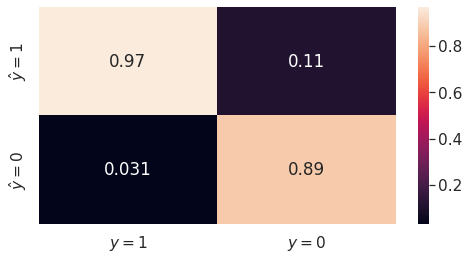

In [ ]:
threshold = 0.55

y_hat = np.where(P_hat > threshold, 1, 0)
y_test = Y_test2.reshape([Y_test2.shape[0], 1])

total = len(y_hat)

plot_confusion_matrix(y_test, y_hat, beta = 2)   

# Using data from other dataset

In [ ]:
def predictionPerGroup(groupName, dataframe, ClassHeader, TextHeader):
  group = dataframe.groupby(ClassHeader).get_group(groupName)
  token = tokenizer.bert_encode(group[TextHeader], max_len=max_len)
  P_hat = model.predict(token)
  return P_hat, group

In [ ]:
test_df = pd.read_csv('/content/drive/Shareddrives/Projeto IBRA USP/Coleta de Dados/Datasets - IBRA/collected_tweets/NAACL_SRW_2016.csv')#, encoding = 'latin-1')
test_label_df = pd.read_csv('/content/drive/Shareddrives/Projeto IBRA USP/Coleta de Dados/Datasets - IBRA/collected_tweets/NAACL_SRW_2016Labels.csv', header = None)
test_df = pd.concat([test_df,test_label_df], axis = 1)
test_df.columns = ['tweet','class']
test_df = test_df.dropna()
test_df.head()

,tweet,class
0,These girls are the equivalent of the irritati...,racism
1,Drasko they didn't cook half a bird you idiot ...,racism
2,Hopefully someone cooks Drasko in the next ep ...,racism
3,of course you were born in serbia...you're as ...,racism
4,So Drasko just said he was impressed the girls...,racism


In [ ]:
sexism_group = test_df.groupby("class").get_group("sexism")
sexism_group['class'] = np.ones(len(sexism_group))
none_group = test_df.groupby("class").get_group("none")
none_group['class'] = np.zeros(len(none_group))
test_df = pd.concat([sexism_group,none_group])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,tweet,class
12,its melting because you didnt put it in the fr...,1.0
13,"@mykitchenrules Girls, please don't let the le...",1.0
14,Sorry #killerblondes but you are a long LONG w...,1.0
15,I think they're deconstraucted Pro . . . mowho...,1.0
16,#mkr deconstructed by girls that have deconstr...,1.0


In [ ]:
huge_df2 = generalSample.append(test_df, ignore_index = True)
huge_df2 = huge_df2.replace(np.nan,0)
token = tokenizer.bert_encode(huge_df2['tweet'], max_len=max_len)
P_hat2 = model.predict(token)
prediction_df2 = pd.DataFrame(P_hat2, columns = ['Prediction'])
prediction_df2 = pd.concat([huge_df2['tweet'],prediction_df2], axis=1)


Y_test2 = huge_df2['class'].to_numpy()

In [ ]:
testHateGroup = test_df.groupby('class').get_group(1)

count = 0
for text in testHateGroup['tweet']:
  if text in prediction_df2[prediction_df2['Prediction'] > 0.55]['tweet'].unique():
    count += 1

print('There were',count, 'hate speech tweets found in the dataset of', len(testHateGroup['tweet']),'expected')

There were 1186 hate speech tweets found in the dataset of 2711 expected


TP = 1186    FP = 3544
FN = 1525    TN = 22727

Accuracy = 23913 / 28982 (0.825098)
Recall = 1186 / 2711 (0.437477)
Precision = 1186 / 4730 (0.250740)
Fbeta Score = 0.318774


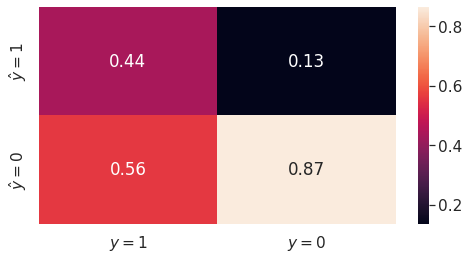

In [ ]:
threshold = 0.55

y_hat = np.where(P_hat2 > threshold, 1, 0)
y_test = Y_test2.reshape([Y_test2.shape[0], 1])

total = len(y_hat)

plot_confusion_matrix(y_test, y_hat)  